<a href="https://colab.research.google.com/github/thopiyawan/dl-nll_pj/blob/main/62199130237_Image_Classification_model_100epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Data Preparation**
- upload images on google drive

In [2]:
#import tensorflow และ library อื่นๆที่จำเป็นมา
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython.display import Image
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Activation, Dense, Dropout, Flatten


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
cd /content/drive/My Drive/

/content/drive/My Drive


In [5]:
#ขั้นตอนการเตรียมข้อมูลจริง
import pathlib
path = "2020-lecture/DS 521 nn & dl/project_img/foods_dataset" #ที่อยู่ของข้อมูล
data_dir = pathlib.Path(path)
image_count = len(list(data_dir.glob('*/*.jpg')))

#เช็คจำนวนรูปภาพที่จะทำ Train 
print(image_count)


5000


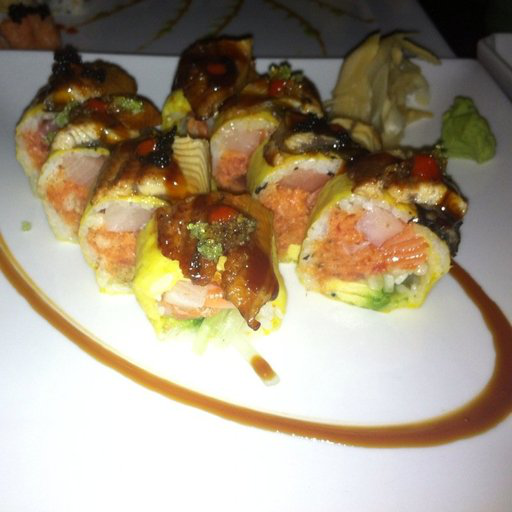

In [6]:
# เรียกดูตัวอย่างภาพ sushi ที่เราจะทำการ Train
sushi = list(data_dir.glob('sushi/*'))
PIL.Image.open(str(sushi[1]))

In [7]:
#กำหนด Dataset ของข้อมูลที่จะ Train
# Batch_size : กำหนดขนาดการอ่านข้อมูลแต่ละรอบ
# img_height : กำหนดความสูงของรูปภาพ
# img_width : กำหนดความกว้างของรูปภาพ
# ถัดมาเรามาทำการแบ่งรูปภาพทั้งหมดโดยจะทำการแบ่งเป็นการ Train 80% และ validation 20%
batch_size = 32
img_height = 224
img_width = 224

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="training",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="validation",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)

Found 5000 files belonging to 5 classes.
Using 4000 files for training.
Found 5000 files belonging to 5 classes.
Using 1000 files for validation.


In [9]:
#ดูชื่อ Class ของข้อมูล มีทั้งหมด 5 class
class_names = train_ds.class_names
print(class_names)
len(class_names)

['fried_rice', 'pad_thai', 'ramen', 'sushi', 'waffles']


5

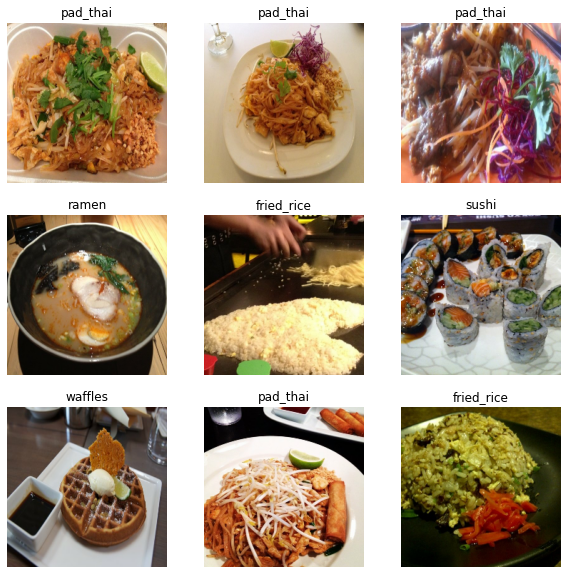

In [10]:
#เรามาแสดงผลภาพ 9 ภาพแรกจากชุดข้อมูลการ Train
plt.figure(figsize=(10, 10)) #ขนาดของรูปภาพที่จะให้แสดง
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:  
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [12]:
# ทำการ normalization เพื่อแปลงค่าสีให้สอดคล้องกับการทำ CNN
#โดยเรียกใช้ layer จาก Tensorflow.keras และทำการ Rescale จาก 0–255 เป็น 0–1
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


**2. Define Model**

In [13]:
#กำหนด num_classes เป็น 5 เพราะมีคลาสทั้งหมด 5 คลาส
num_classes = 5
model = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
layers.Conv2D(16, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(32, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(128, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(128, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(128, activation='relu'),
layers.Dense(num_classes)])




**3. Compile the model**<p>
แสดงค่าความแม่นยำ 

In [14]:
model.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

**4. Train the model**

In [15]:
# epochs : คือจำนวนในการ Train
epochs=100
# history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)


filepath = "2020-lecture/DS 521 nn & dl/project_img/"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, mode='min', monitor='val_loss', verbose=2, save_best_only=True)
callbacks_list = [checkpoint]
history = model.fit(train_ds,validation_data=val_ds, callbacks=callbacks_list, verbose=2, epochs=epochs)



Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.45977, saving model to 2020-lecture/DS 521 nn & dl/project_img/
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: 2020-lecture/DS 521 nn & dl/project_img/assets
125/125 - 1119s - loss: 1.5330 - accuracy: 0.3070 - val_loss: 1.4598 - val_accuracy: 0.3720
Epoch 2/100

Epoch 00002: val_loss improved from 1.45977 to 1.32132, saving model to 2020-lecture/DS 521 nn & dl/project_img/
INFO:tensorflow:Assets written to: 2020-lecture/DS 521 nn & dl/project_img/assets
125/125 - 21s - loss: 1.3364 - accuracy: 0.4400 - val_loss: 1.3213 - val_accuracy: 0.4380
Epoch 3/100

Epoch 00003: val_loss improved from 1.32132 to 1.22617, saving model to 2020-lecture/DS 521 nn & dl/project_img/
INFO:tensorflow:Assets written to: 2020-lectur

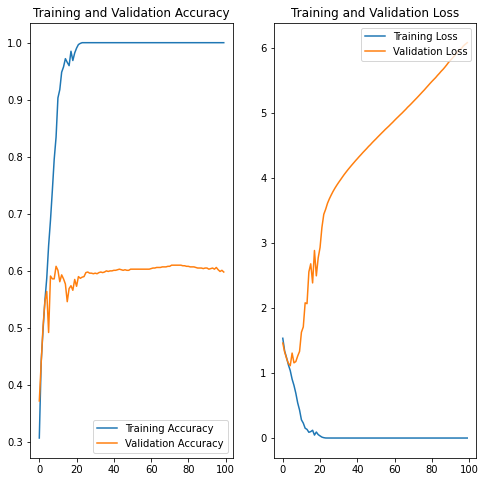

In [16]:
#มาดูผลลัพธ์ Data Visualization กันเลย
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


**5. Prediction**


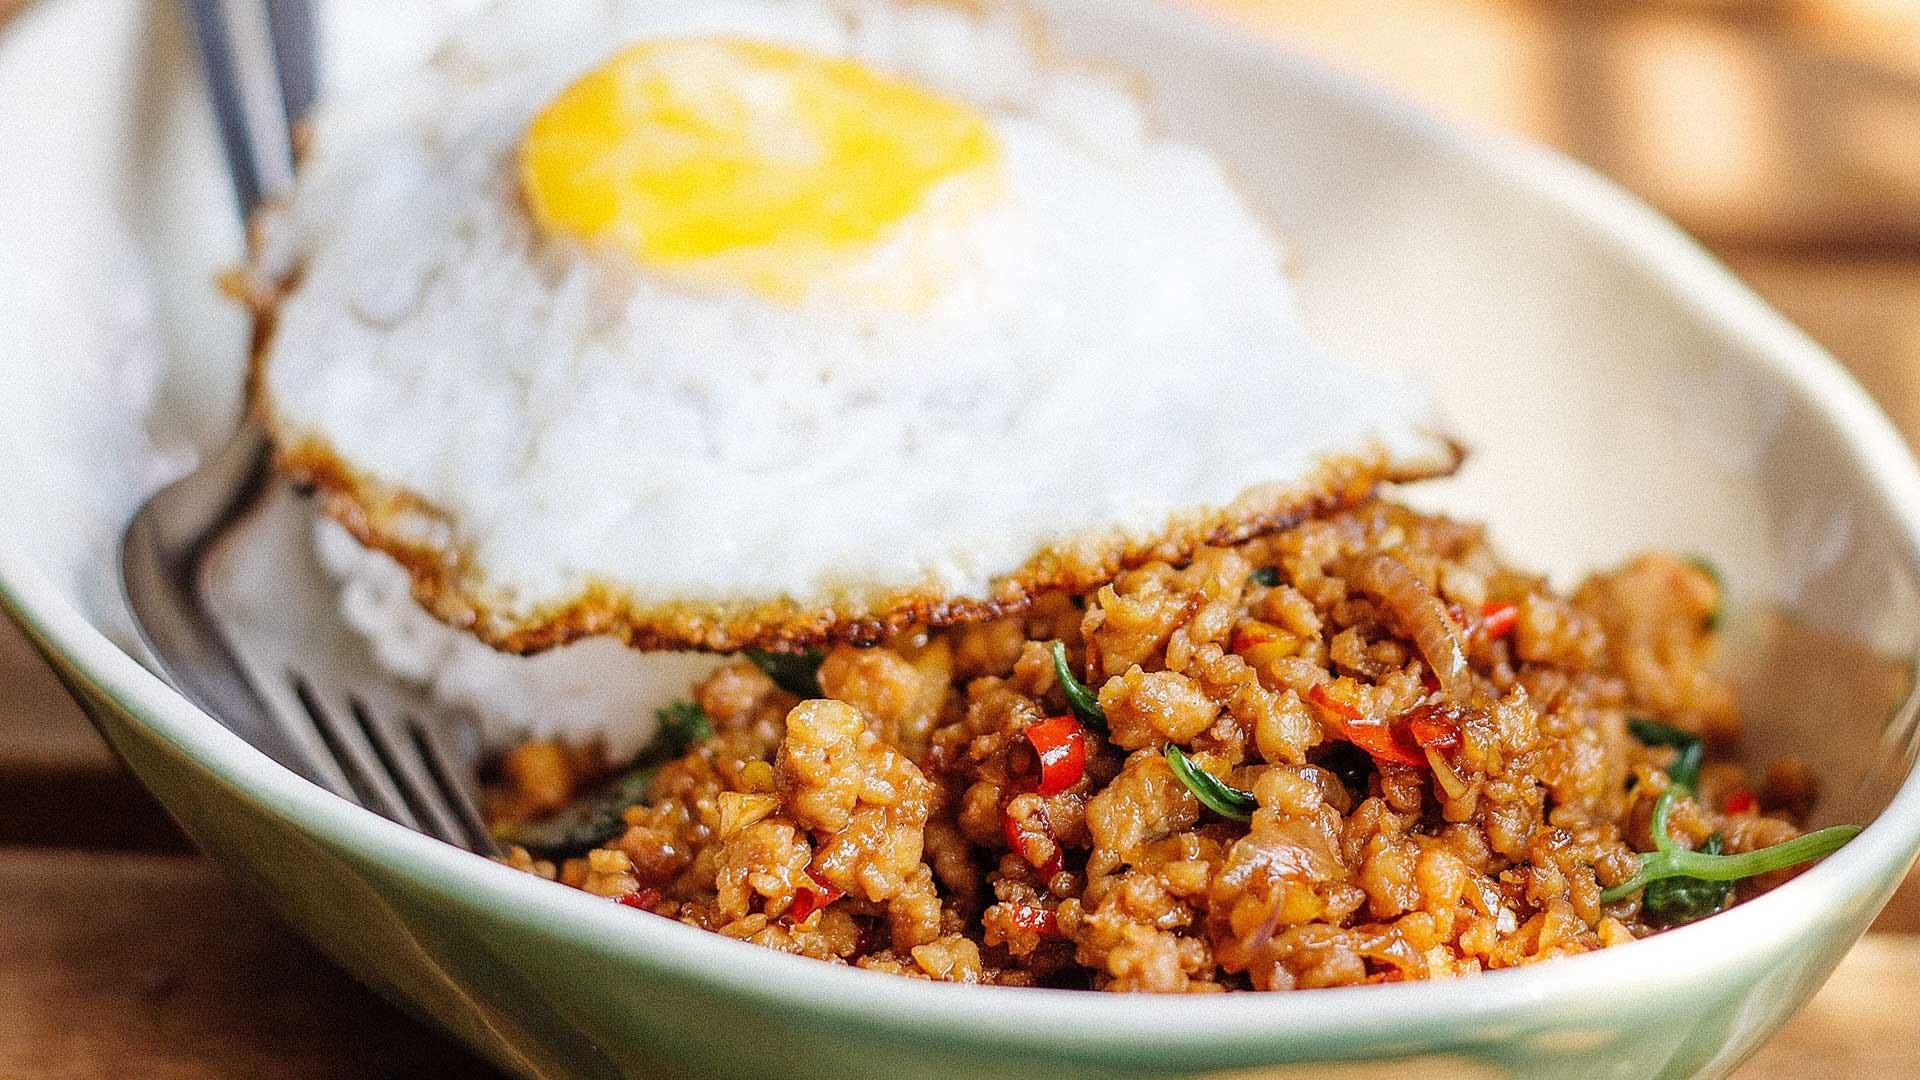

this image most likely belongs to fried_rice with a 100.00 percent confidence


In [17]:
#prediction
# Prediction
# สุดท้ายเรามาทำการทดสอบหรือทำนายตัว Model ที่เรา Train มาด้วยข้อมูลที่เราเตรียมไว้
path = "2020-lecture/DS 521 nn & dl/project_img/test_data/kp1.jpg" #ที่อยู่ของข้อมูล
img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
img_arr = keras.preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr,0)
predictions = model.predict(img_arr)
score = tf.nn.softmax(predictions[0])
display(Image(filename=path))
print("this image most likely belongs to {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))

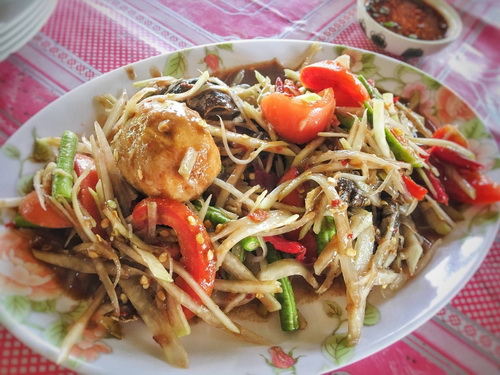

this image most likely belongs to pad_thai with a 100.00 percent confidence


In [18]:
path = "2020-lecture/DS 521 nn & dl/project_img/test_data/st1.jpg" #ที่อยู่ของข้อมูล
img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
img_arr = keras.preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr,0)
predictions = model.predict(img_arr)
score = tf.nn.softmax(predictions[0])
display(Image(filename=path))
print("this image most likely belongs to {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))

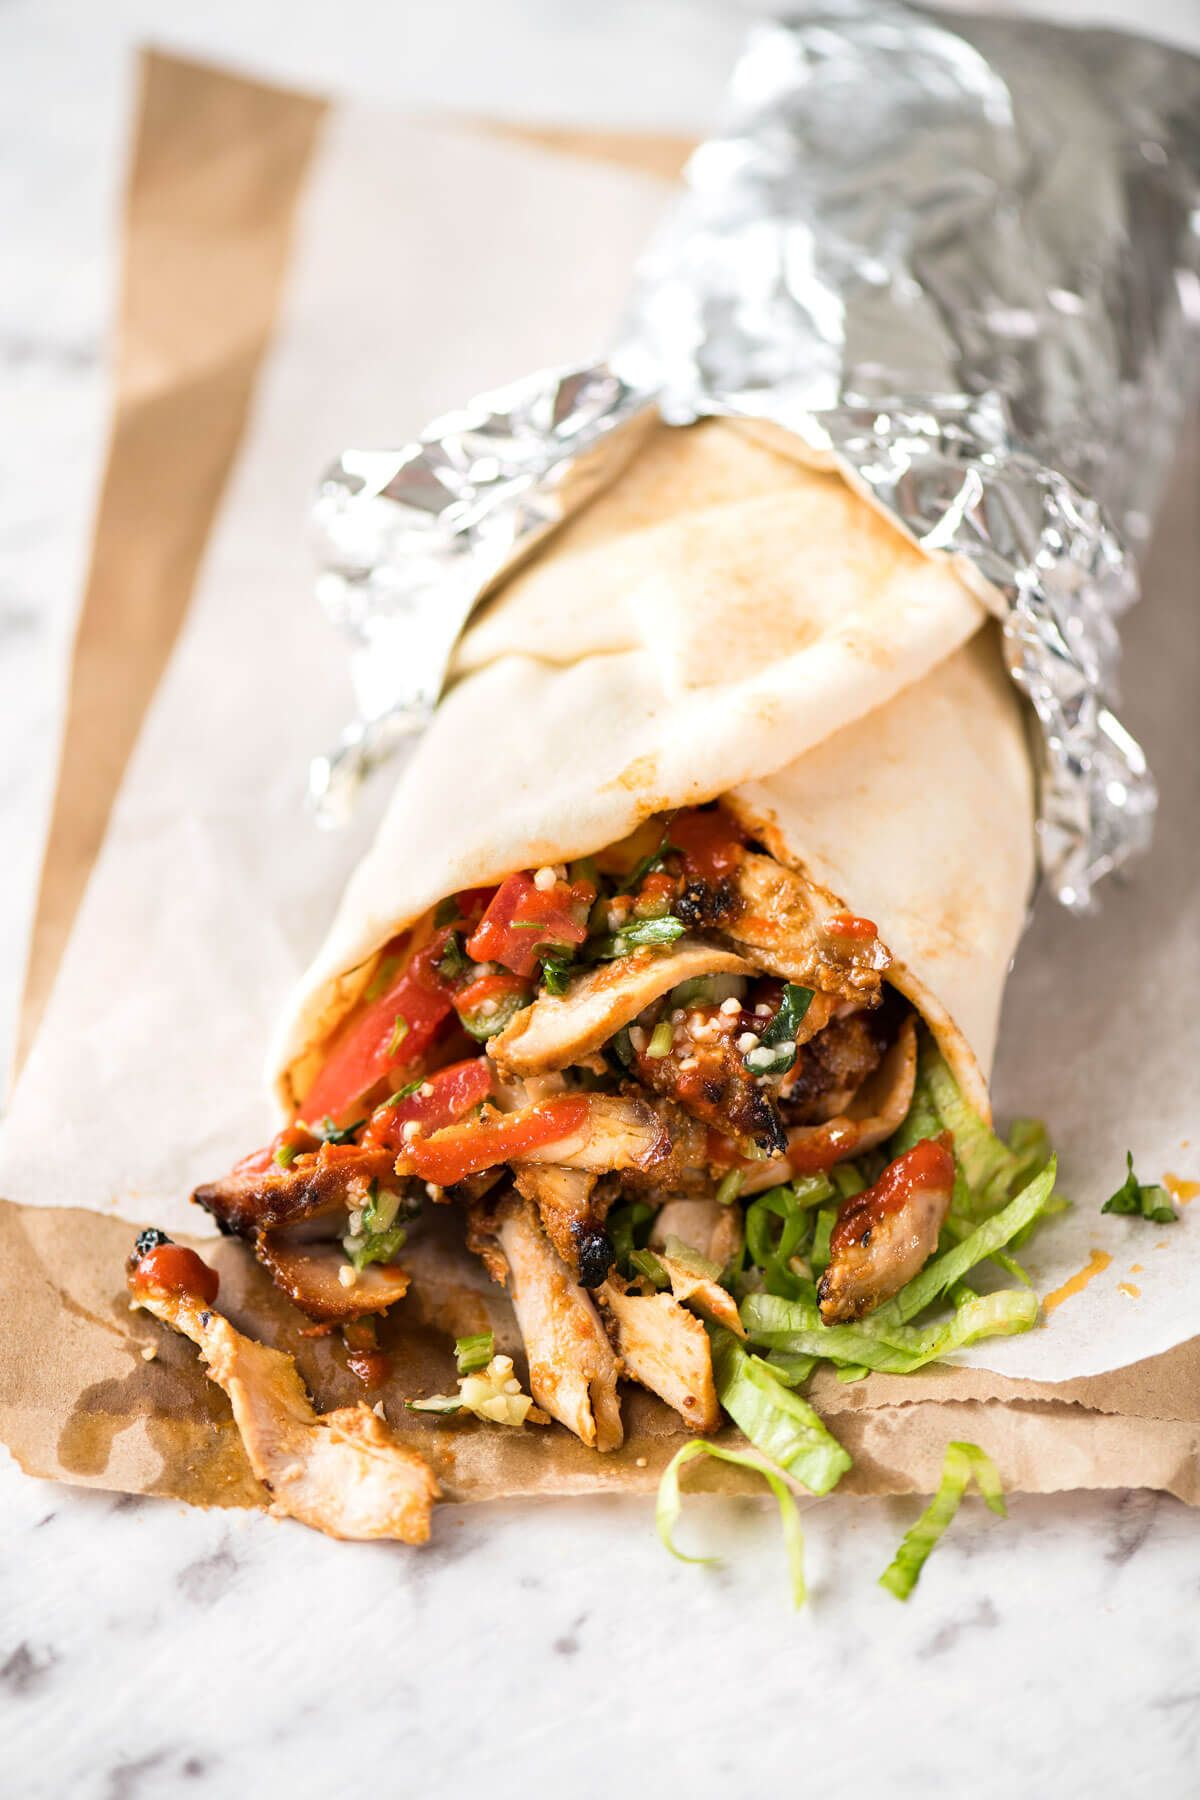

this image most likely belongs to waffles with a 100.00 percent confidence


In [19]:
path = "2020-lecture/DS 521 nn & dl/project_img/test_data/kb1.jpg" #ที่อยู่ของข้อมูล
img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
img_arr = keras.preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr,0)
predictions = model.predict(img_arr)
score = tf.nn.softmax(predictions[0])
display(Image(filename=path))
print("this image most likely belongs to {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))

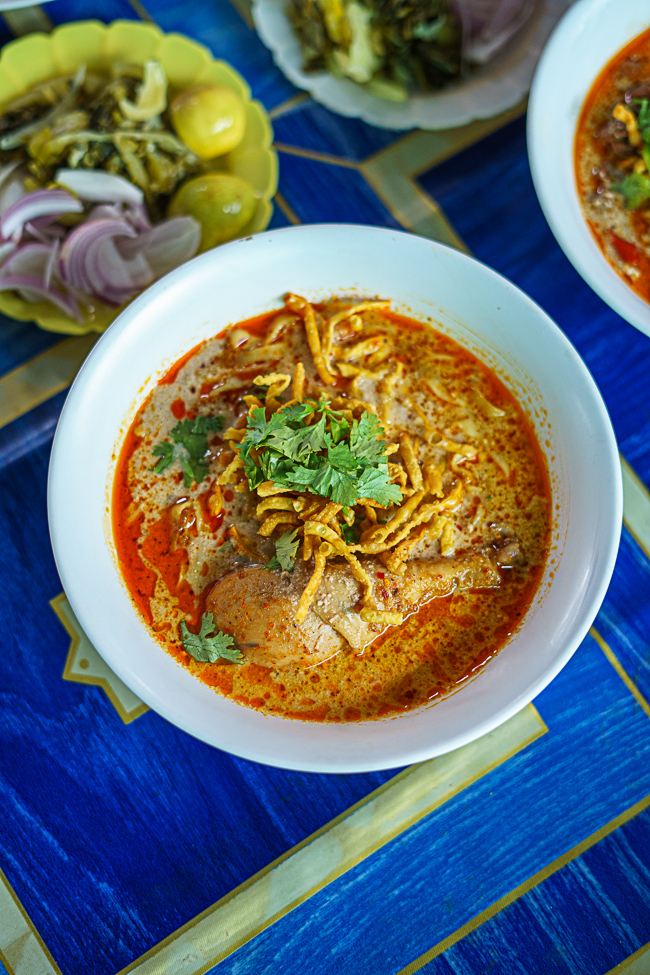

this image most likely belongs to ramen with a 95.28 percent confidence


In [20]:
path = "2020-lecture/DS 521 nn & dl/project_img/test_data/ks1.jpg" #ที่อยู่ของข้อมูล
img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
img_arr = keras.preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr,0)
predictions = model.predict(img_arr)
score = tf.nn.softmax(predictions[0])
display(Image(filename=path))
print("this image most likely belongs to {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))

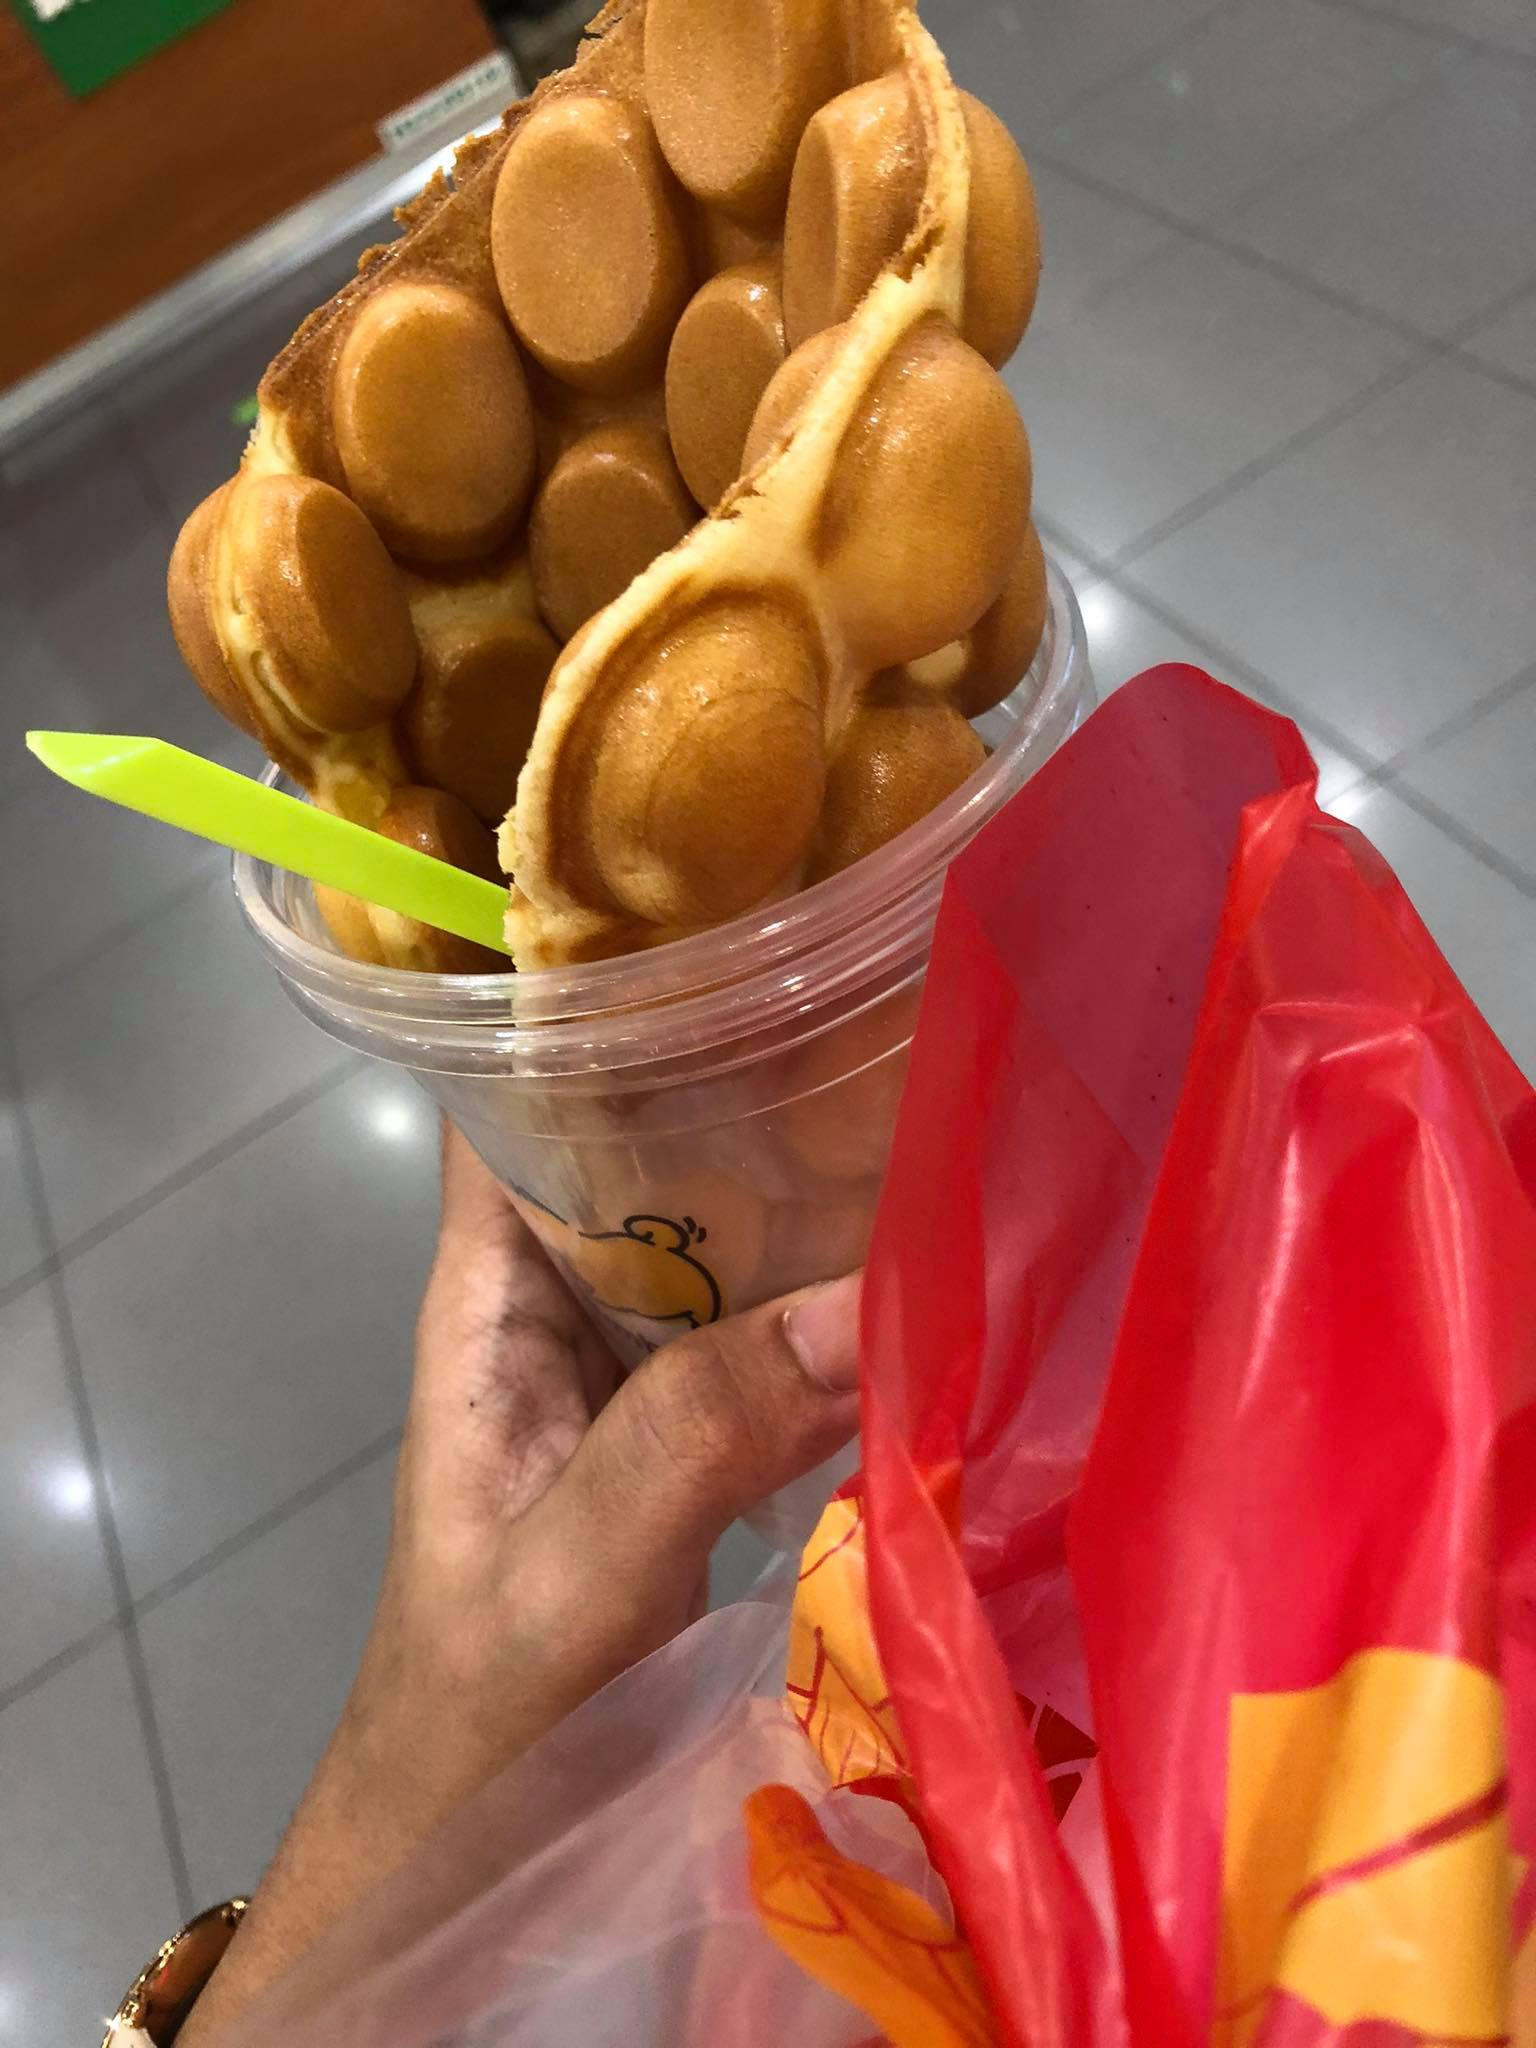

this image most likely belongs to waffles with a 100.00 percent confidence


In [21]:
path = "2020-lecture/DS 521 nn & dl/project_img/test_data/test_1.jpg" #ที่อยู่ของข้อมูล
img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
img_arr = keras.preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr,0)
predictions = model.predict(img_arr)
score = tf.nn.softmax(predictions[0])
display(Image(filename=path))
print("this image most likely belongs to {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))

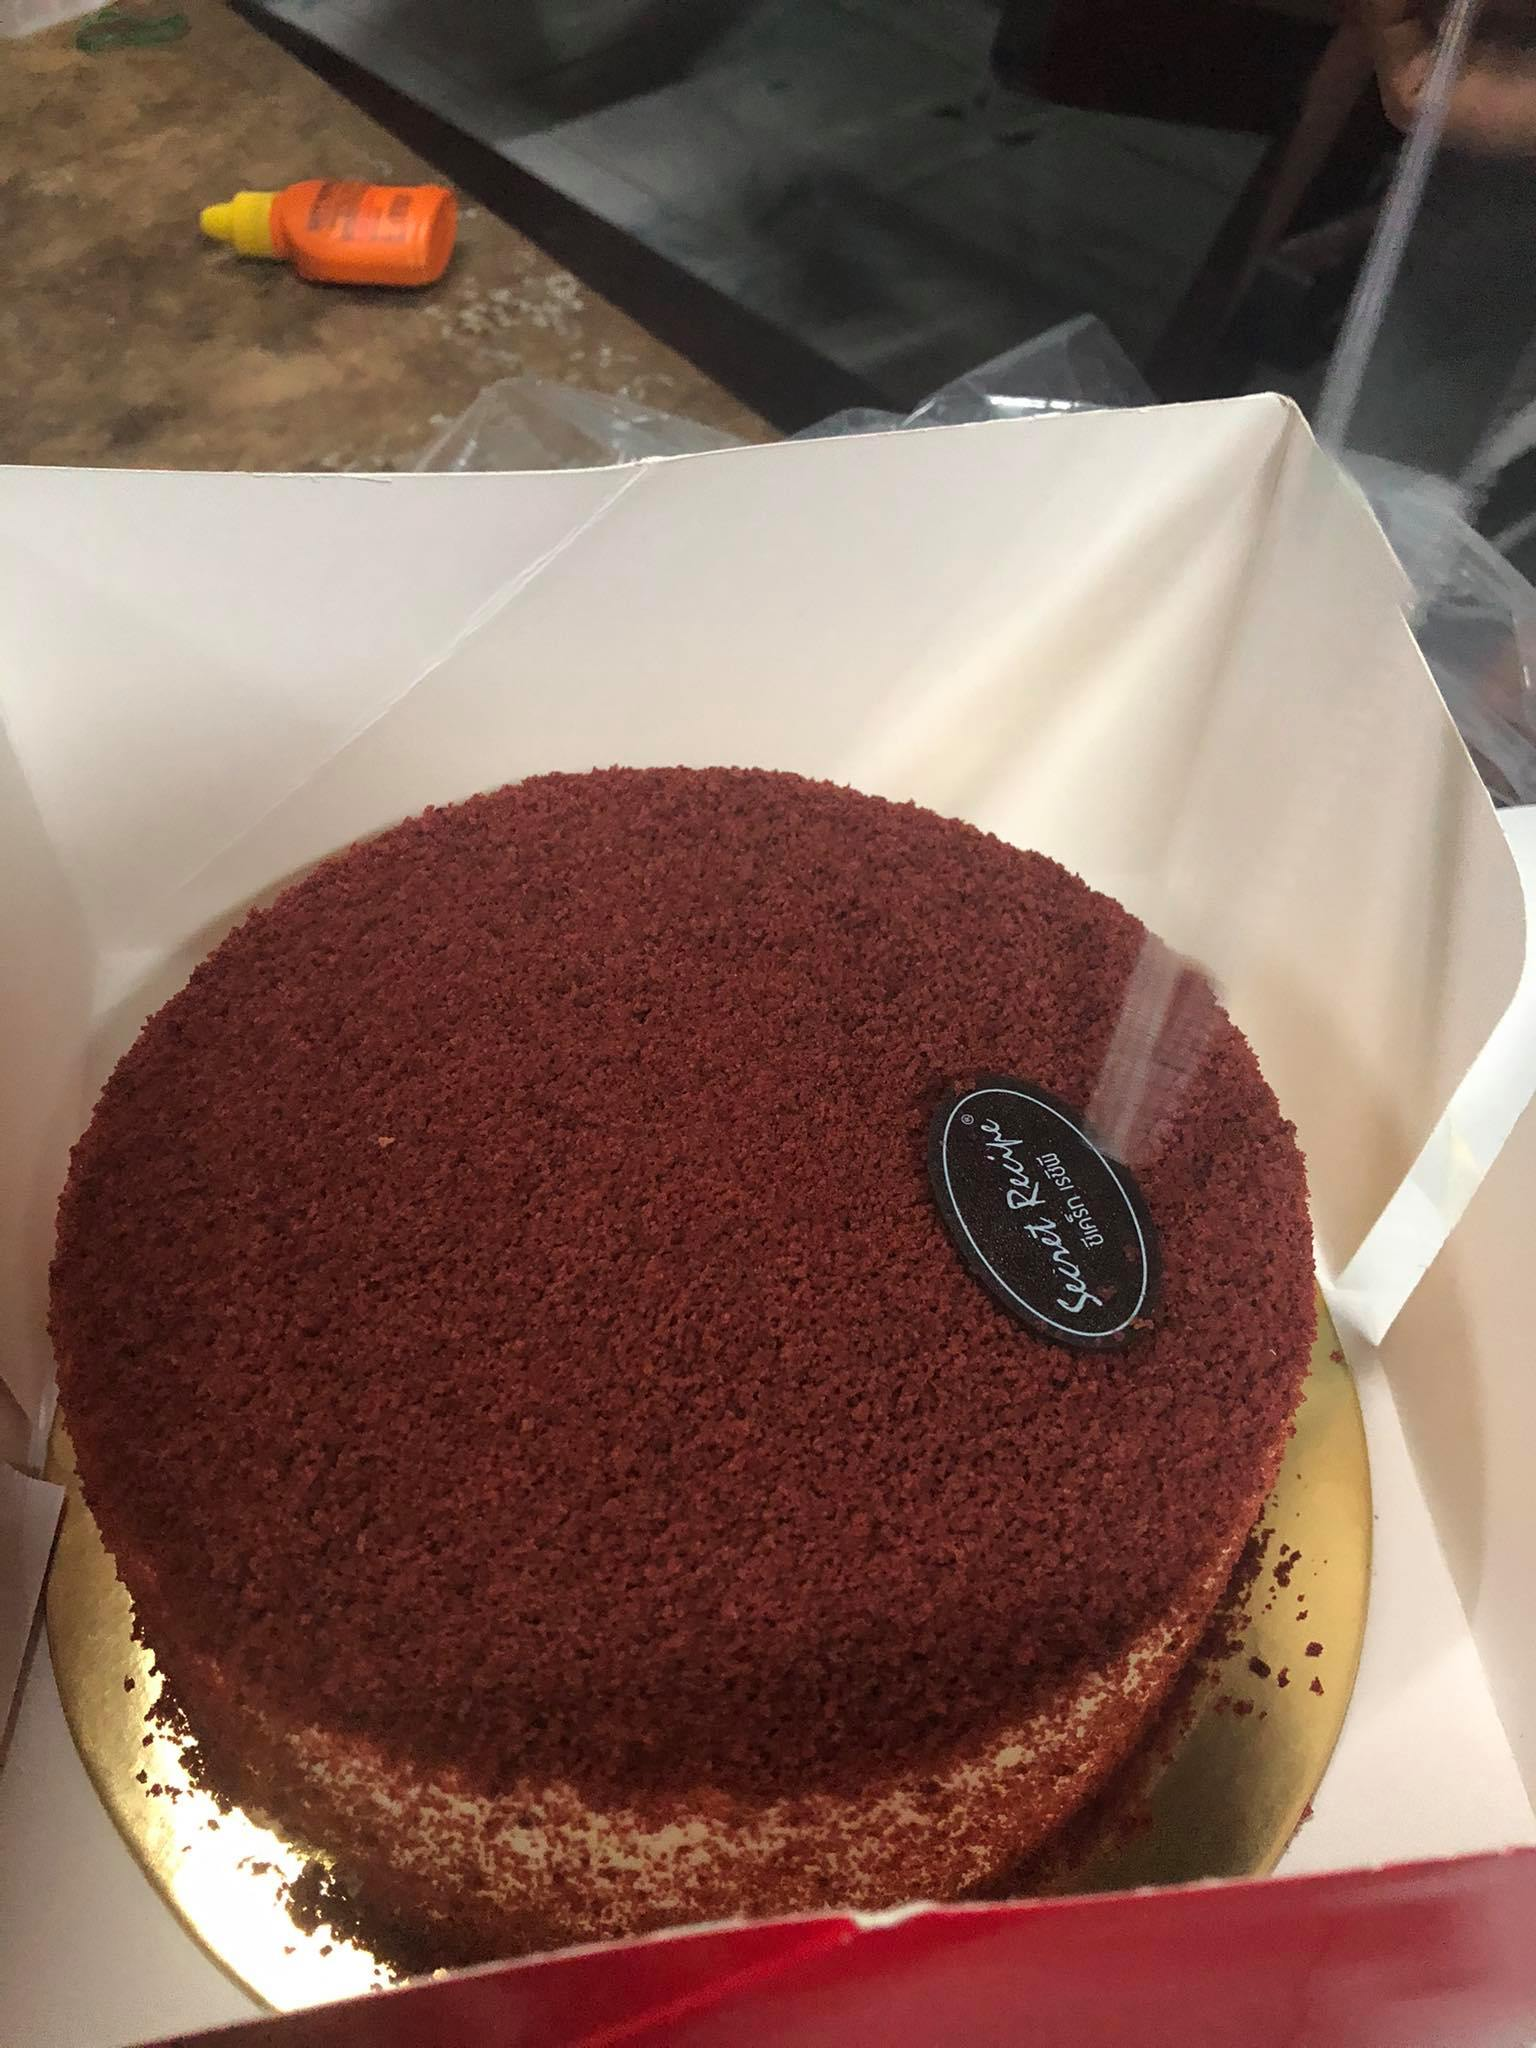

this image most likely belongs to ramen with a 99.93 percent confidence


In [22]:
path = "2020-lecture/DS 521 nn & dl/project_img/test_data/test_2.jpg" #ที่อยู่ของข้อมูล
img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
img_arr = keras.preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr,0)
predictions = model.predict(img_arr)
score = tf.nn.softmax(predictions[0])
display(Image(filename=path))
print("this image most likely belongs to {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))

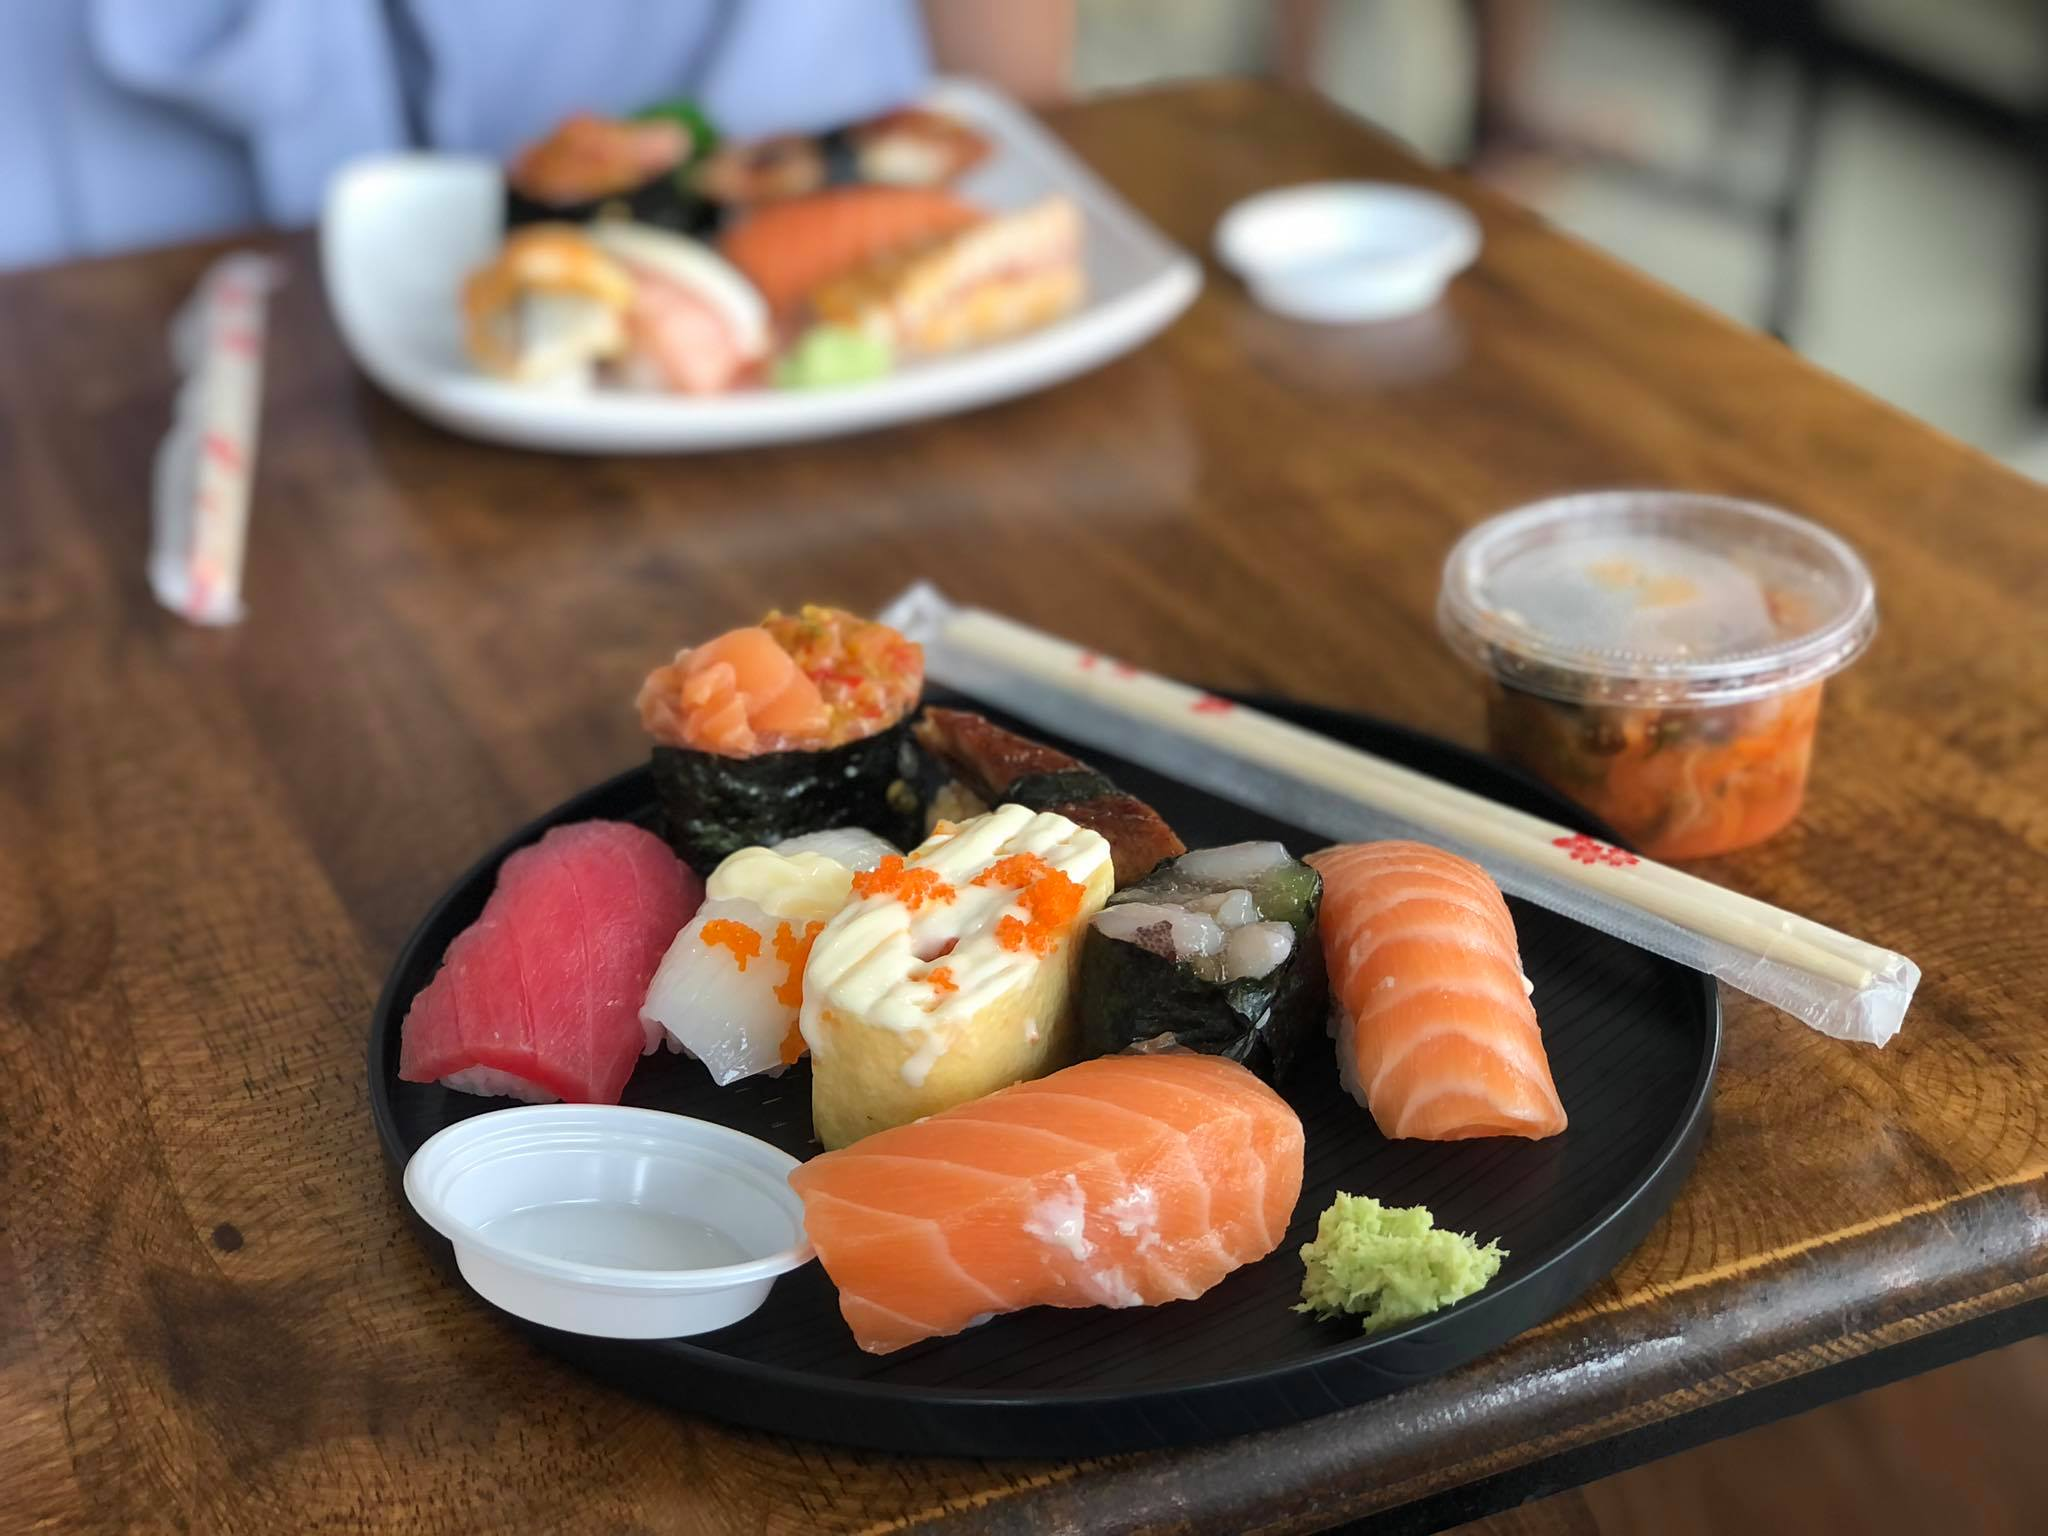

this image most likely belongs to sushi with a 100.00 percent confidence


In [23]:
path = "2020-lecture/DS 521 nn & dl/project_img/test_data/test_3.jpg" #ที่อยู่ของข้อมูล
img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
img_arr = keras.preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr,0)
predictions = model.predict(img_arr)
score = tf.nn.softmax(predictions[0])
display(Image(filename=path))
print("this image most likely belongs to {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))

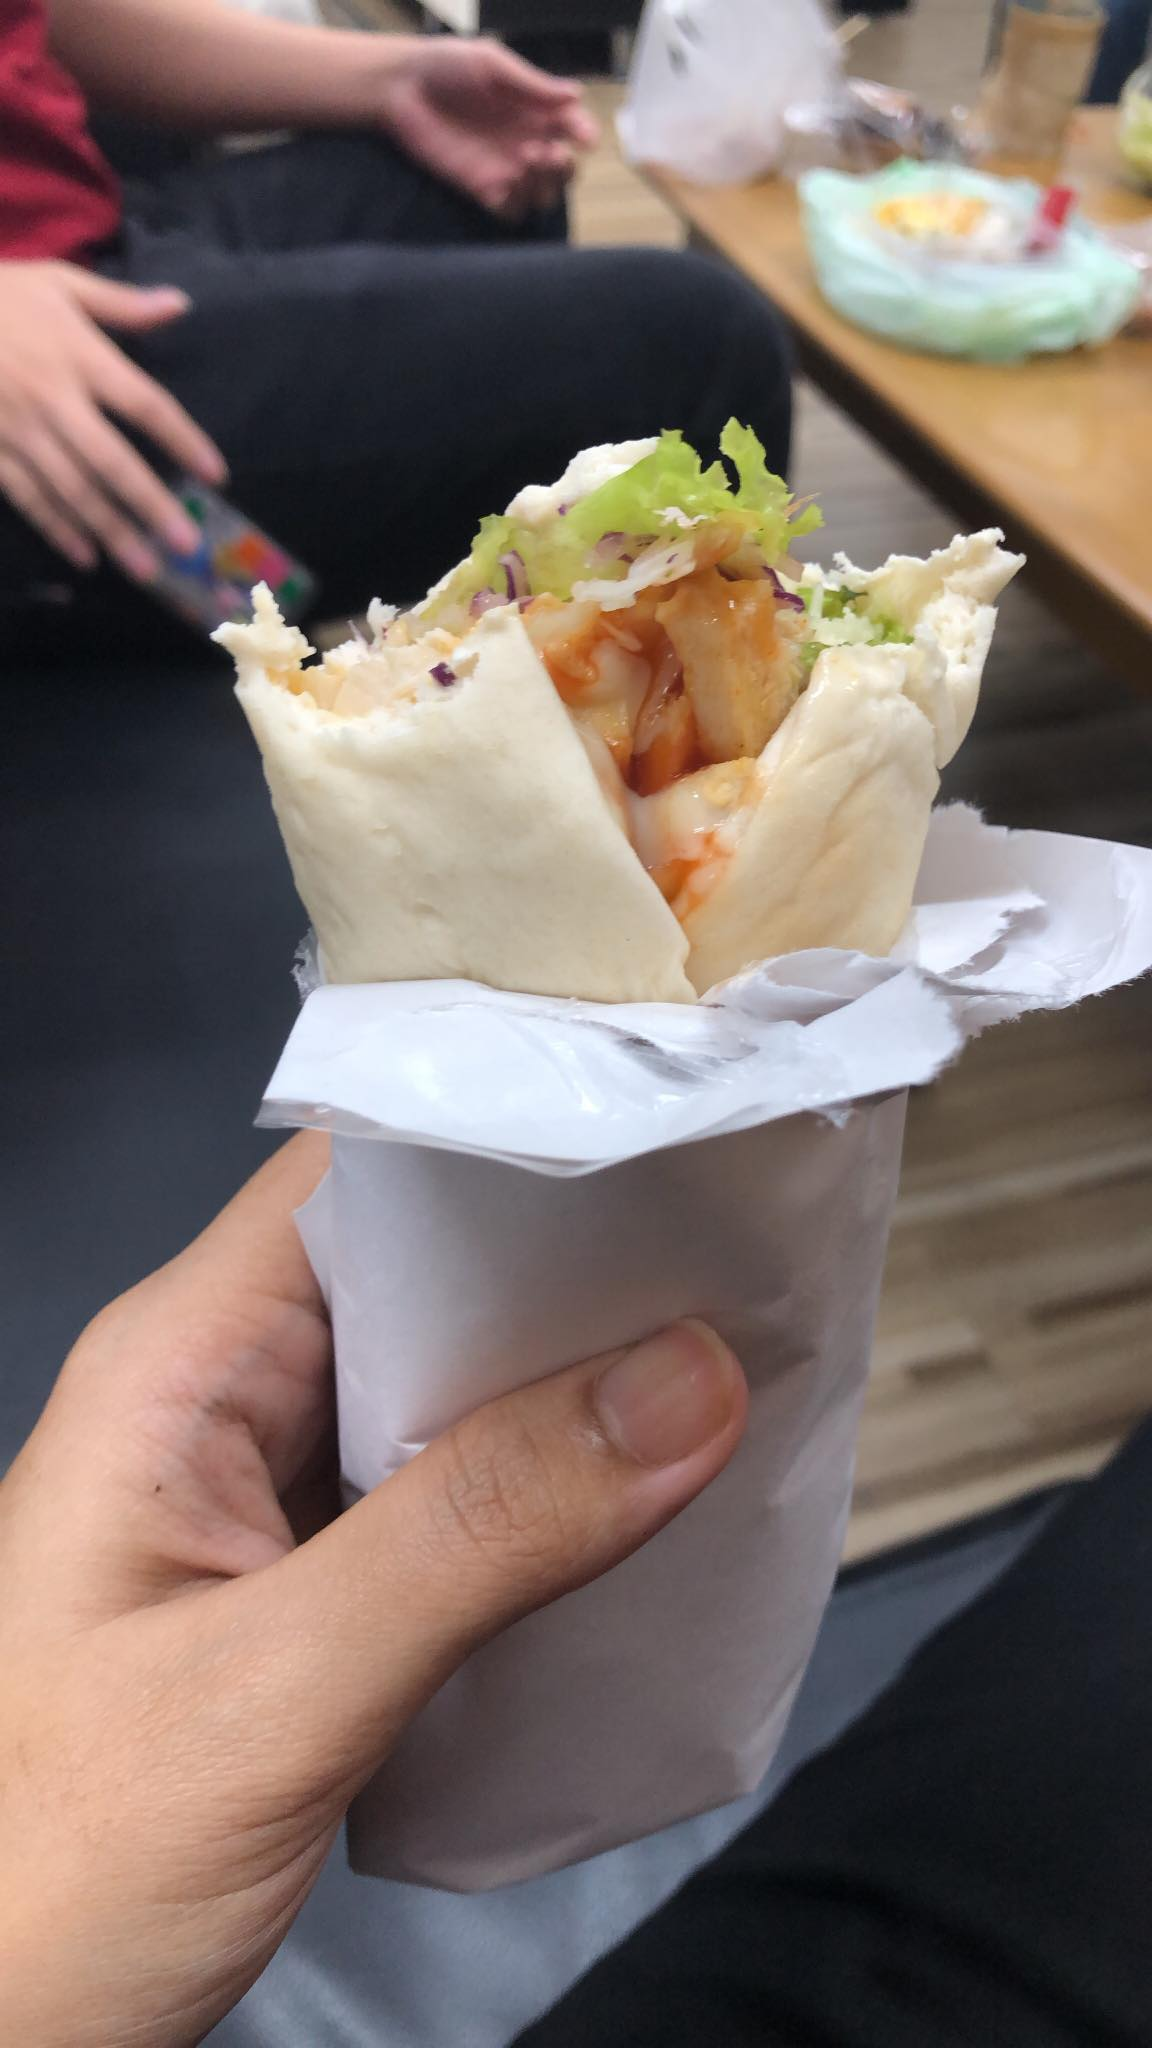

this image most likely belongs to sushi with a 66.77 percent confidence


In [24]:
path = "2020-lecture/DS 521 nn & dl/project_img/test_data/test_4.jpg" #ที่อยู่ของข้อมูล
img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
img_arr = keras.preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr,0)
predictions = model.predict(img_arr)
score = tf.nn.softmax(predictions[0])
display(Image(filename=path))
print("this image most likely belongs to {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))

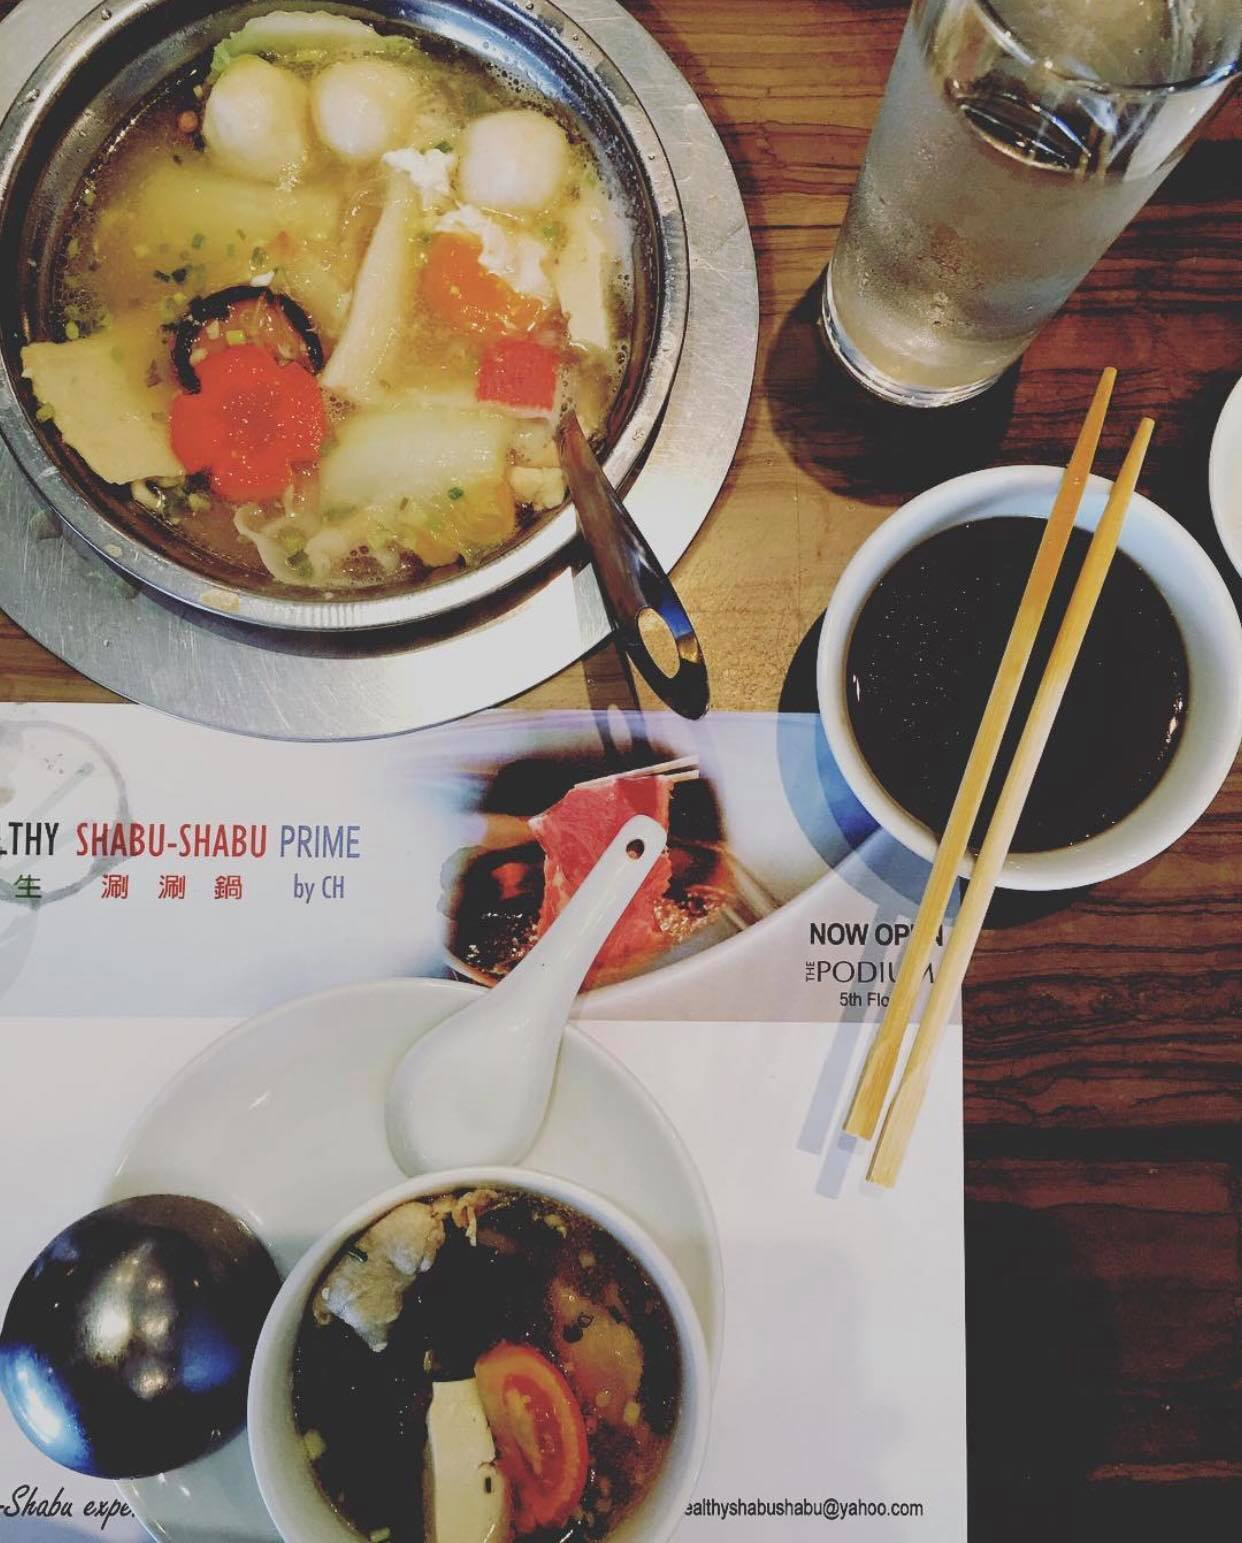

this image most likely belongs to sushi with a 100.00 percent confidence


In [25]:
path = "2020-lecture/DS 521 nn & dl/project_img/test_data/test_5.jpg" #ที่อยู่ของข้อมูล
img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
img_arr = keras.preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr,0)
predictions = model.predict(img_arr)
score = tf.nn.softmax(predictions[0])
display(Image(filename=path))
print("this image most likely belongs to {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))

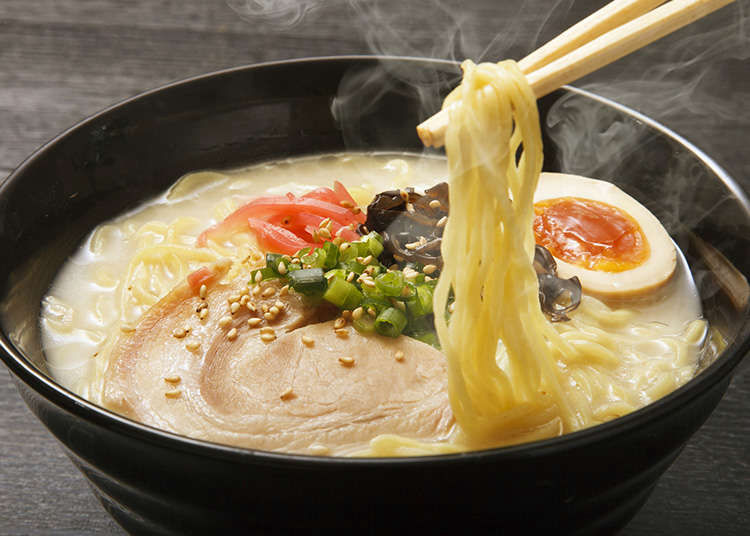

this image most likely belongs to ramen with a 100.00 percent confidence


In [26]:
path = "2020-lecture/DS 521 nn & dl/project_img/test_data/test_6.jpg" #ที่อยู่ของข้อมูล
img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
img_arr = keras.preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr,0)
predictions = model.predict(img_arr)
score = tf.nn.softmax(predictions[0])
display(Image(filename=path))
print("this image most likely belongs to {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))

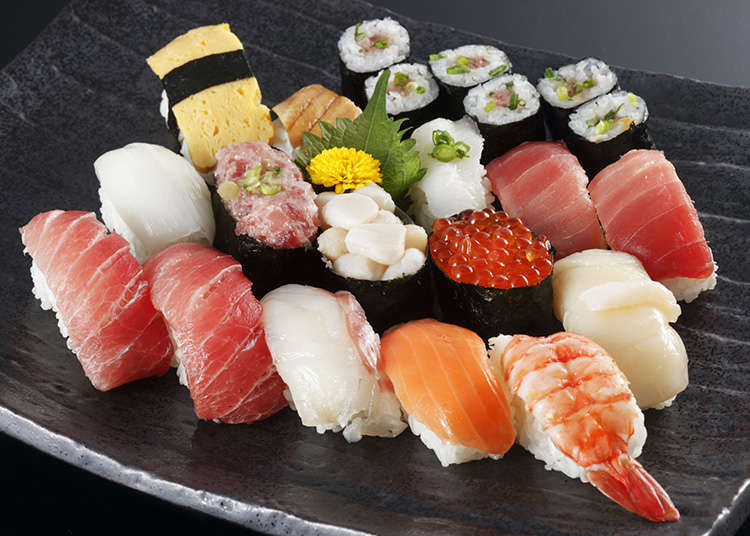

this image most likely belongs to waffles with a 58.11 percent confidence


In [27]:
path = "2020-lecture/DS 521 nn & dl/project_img/test_data/test_7.jpg" #ที่อยู่ของข้อมูล
img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
img_arr = keras.preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr,0)
predictions = model.predict(img_arr)
score = tf.nn.softmax(predictions[0])
display(Image(filename=path))
print("this image most likely belongs to {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))

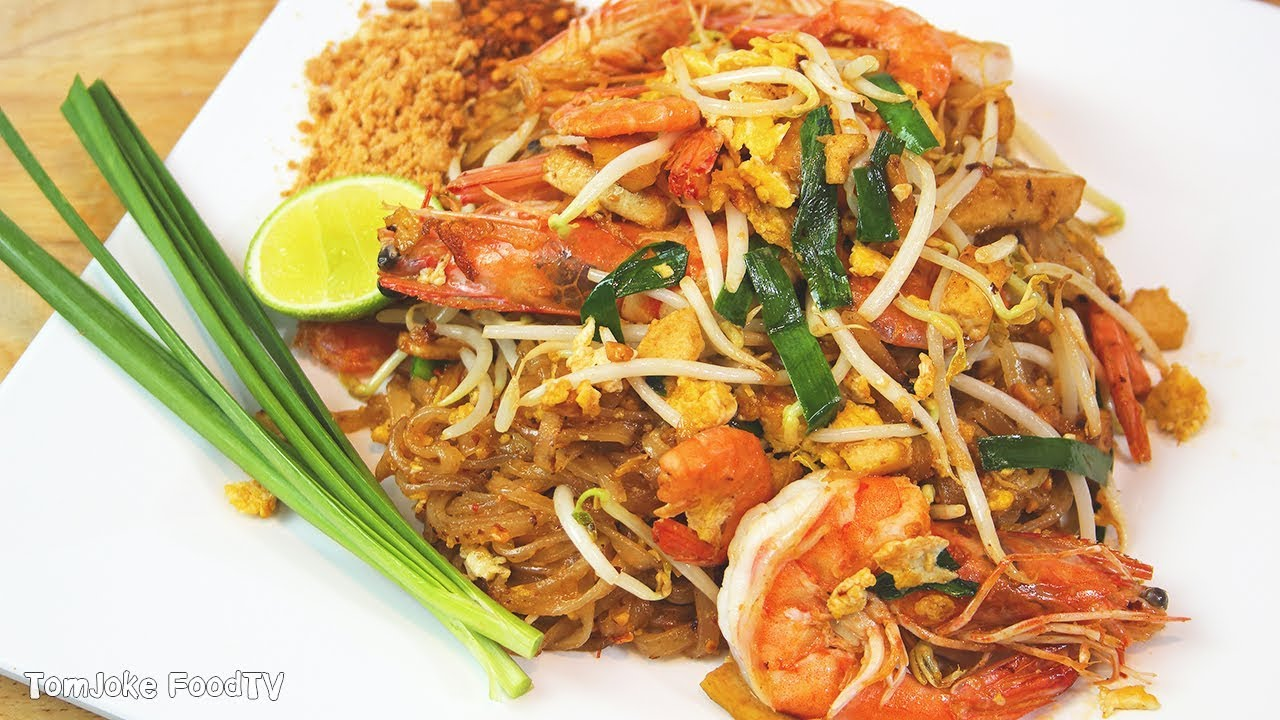

this image most likely belongs to pad_thai with a 100.00 percent confidence


In [28]:
path = "2020-lecture/DS 521 nn & dl/project_img/test_data/test_8.jpg" #ที่อยู่ของข้อมูล
img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
img_arr = keras.preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr,0)
predictions = model.predict(img_arr)
score = tf.nn.softmax(predictions[0])
display(Image(filename=path))
print("this image most likely belongs to {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))

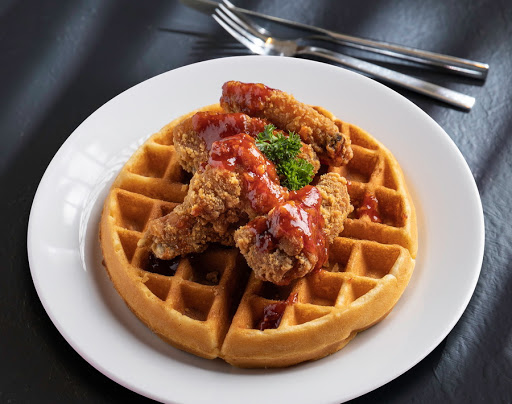

this image most likely belongs to pad_thai with a 99.98 percent confidence


In [29]:
path = "2020-lecture/DS 521 nn & dl/project_img/test_data/test_9.jpg" #ที่อยู่ของข้อมูล
img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
img_arr = keras.preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr,0)
predictions = model.predict(img_arr)
score = tf.nn.softmax(predictions[0])
display(Image(filename=path))
print("this image most likely belongs to {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))

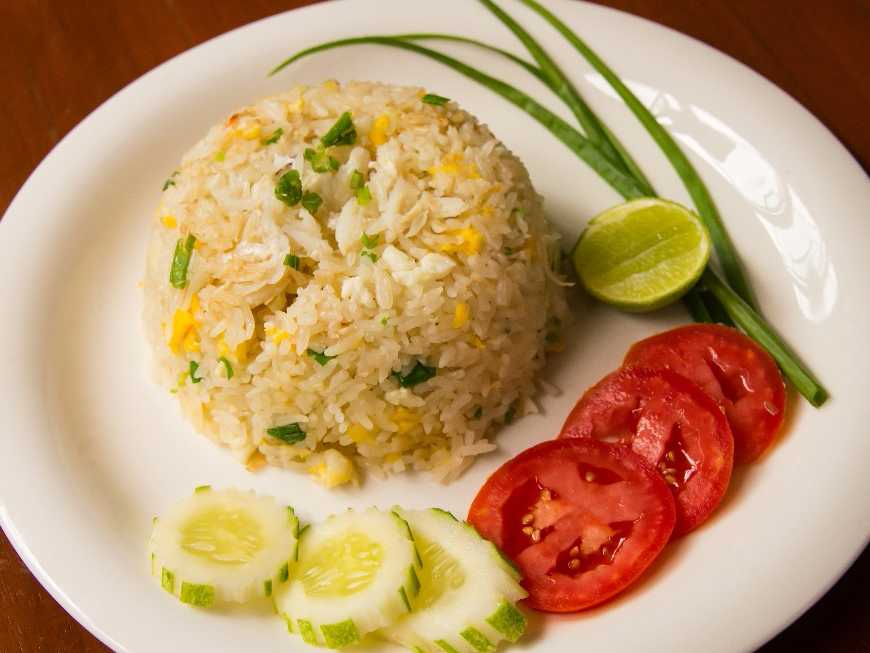

this image most likely belongs to ramen with a 99.57 percent confidence


In [30]:
path = "2020-lecture/DS 521 nn & dl/project_img/test_data/test_10.jpg" #ที่อยู่ของข้อมูล
img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
img_arr = keras.preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr,0)
predictions = model.predict(img_arr)
score = tf.nn.softmax(predictions[0])
display(Image(filename=path))
print("this image most likely belongs to {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100*np.max(score)))